In [91]:
########## IN THIS PART FINISH THE ITERATIVE ALGORITHM

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

data = pd.read_csv('C:/Users/adite/Downloads/demo_inc.csv')
print(data.columns)

# Determine unique countries and time periods
unique_countries = data['country'].unique()
time_periods = len(data) // len(unique_countries)

# Initialize a copy of data to manipulate
data_with_time = data.copy()

# Initialize 'time' column
data_with_time['time'] = 0
current_country = None
time_counter = 0

# Update the 'time' column for each row
for index, row in data_with_time.iterrows():
    if row['country'] != current_country:
        current_country = row['country']
        time_counter = 0
    data_with_time.at[index, 'time'] = time_counter
    time_counter += 1

# # Initialize columns for each country in each time
# for i, country in enumerate(unique_countries):
#     for j in range(time_periods):
#         data_with_time[f'{country}_time_{j}'] = 0
    
# # Fill the dummy variables
# for i, country in enumerate(unique_countries):
#     for j in range(time_periods):
#         mask = (data_with_time['country'] == country) & (data_with_time['time'] == j)
#         data_with_time.loc[mask, f'{country}_time_{j}'] = 1


# Sort the DataFrame first by 'country' alphabetically and then by 'time' chronologically
data_with_time = data_with_time.sort_values(by=['country', 'time'], ascending=[True, True])

###### SIMPLE WAY TO MAP COUNTRIES TO RESPECTIVE ROWS IN REGULAR DATAFRAME
country_to_rows = dict()
country_to_pos_unique = dict()
unique_countries = data_with_time['country'].unique()
for i, country in enumerate(unique_countries):
    print(country)
    country_to_pos_unique[country] = i

current_country = unique_countries[0]

for i in range(len(data_with_time)):
    current_country = data_with_time.iloc[i]['country']
    
    if current_country not in country_to_rows.keys():
        current_country_position_list = list()
        current_country_position_list.append(i)
        
        country_to_rows[current_country] = current_country_position_list
    else:
        current_country_position_list = country_to_rows[current_country]
        current_country_position_list.append(i)
print(country_to_rows)


print(current_country_position_list)
print(country_to_pos_unique)

Index(['country', 'fhpolrigaug', 'lag_dem', 'lag_income'], dtype='object')
Algeria
Argentina
Australia
Austria
Belgium
Benin
Bolivia
Brazil
Burkina Faso
Burundi
Cameroon
Canada
Central African Republic
Chad
Chile
China
Colombia
Congo, Dem. Rep.
Congo, Rep.
Costa Rica
Cote d'Ivoire
Cyprus
Denmark
Dominican Republic
Ecuador
Egypt, Arab Rep.
El Salvador
Finland
France
Gabon
Ghana
Greece
Guatemala
Guinea
Honduras
Iceland
India
Indonesia
Iran
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kenya
Korea, Rep.
Luxembourg
Madagascar
Malawi
Malaysia
Mali
Mauritania
Mexico
Morocco
Nepal
Netherlands
New Zealand
Nicaragua
Niger
Nigeria
Norway
Panama
Paraguay
Peru
Philippines
Portugal
Romania
Rwanda
Sierra Leone
Singapore
South Africa
Spain
Sri Lanka
Sweden
Switzerland
Syrian Arab Republic
Taiwan
Tanzania
Thailand
Togo
Trinidad and Tobago
Tunisia
Turkey
Uganda
United Kingdom
United States
Uruguay
Venezuela, RB
Zambia
{'Algeria': [0, 1, 2, 3, 4, 5, 6], 'Argentina': [7, 8, 9, 10, 11, 12, 13], 'Australia': [

In [30]:
import random
import warnings
import numpy as np
import pandas as pd
import time
from sklearn.exceptions import DataConversionWarning
from sklearn.decomposition import PCA
from sklearn import preprocessing
import patsy

# Suppress specific warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*Series.__getitem__ treating keys as positions is deprecated.*")
warnings.filterwarnings("ignore", category=DataConversionWarning)

class InteractiveFixedEffects():
    r"""An implementation of the Interactive Fixed Effects estimator by Bai (2009)."""
    
    n_factors = 0

    log_betas = []
    log_errors = []

    i_encoder = None 
    t_encoder = None

    def __init__(self, n_factors=3):
        self.n_factors = n_factors
    
    def reset_estimation(self):
        self.log_betas = []
        self.log_errors = []
        self.i_encoder = None
        self.t_encoder = None
    
    def fit(self, Y, X, dim1, dim2, atol=10**-14):
        r""" Cleans and defines the data to be used and then calls for the estimation by passing the cleaned data to the `_fit` method.
            * Y: Outputs
            * X: Observable regressors
            * dim1: Indexes for the first dimension (i)
            * dim2: Indexes for the second dimension (t)    
        """
        # Reset previous estimation results
        self.reset_estimation()

        # Normalize factor dimensions labels into indexes
        self.i_encoder = preprocessing.LabelEncoder()
        self.t_encoder = preprocessing.LabelEncoder()
        self.i_encoder.fit(dim1)
        self.t_encoder.fit(dim2)

        _dim1_idx = self.i_encoder.transform(dim1).astype(int)[:,np.newaxis]
        _dim2_idx = self.t_encoder.transform(dim2).astype(int)[:,np.newaxis]

        return self._fit(Y, X, _dim1_idx, _dim2_idx, atol)

    def fit_from_formula(self, formula, data, atol=10**-14):
        """ Recovers the data for estimation from a Patsy formula and then 
            calls the `fit()` method to define the data and complete the estimation.
        """

        # Parse custom formula
        formulas = formula.split('~')
        if len(formulas) != 3:
            raise("Invalid formula. Format is Y~X~ife(I,T)")

        formula = formulas[0] + '~' + formulas[1]
        factors_formula = formulas[2] + '-1'

        def ife(dim1, dim2):
            output = np.hstack([
                        dim1.values[:, np.newaxis], 
                        dim2.values[:, np.newaxis]
                    ])
            return output
        
        Y, X = patsy.dmatrices(formula, data) 
        factors_idx = patsy.dmatrix(factors_formula, data)

        # Rename factor columns
        factors_idx.design_info = patsy.DesignInfo(['dim1', 'dim2'])

        # Call the estimation procedure
        return self.fit(Y, X, factors_idx[:,0], factors_idx[:,1], atol)

    def _fit(self, Y, X, dim1_idx, dim2_idx, atol=10**-14):
        r"""Computes the estimates for the Fixed Effects Estimator."""
        n_factors = self.n_factors

        # Initialize the PCA calculator
        PCA_calc = PCA(n_components=n_factors)

        # Initialize the betas with an initial (bad) guess
        new_betas = np.zeros((X.shape[1], 1))
        old_betas = np.ones((X.shape[1], 1))

        # Count the number of different items in each direction
        N = len(self.i_encoder.classes_)
        T = len(self.t_encoder.classes_)

        # Make an initial guess of Interactive parameters
        Lambda = np.random.random((N,n_factors))
        F = np.random.random((T,n_factors))

        # Compute the inverse of (X'X) to be shared across iterations
        XX_inv = np.linalg.inv(X.T @ X)

        # Logging variables for post-estimation analysis
        self.log_Fs = []
        self.log_lambdas = []
        self.log_betas.append(new_betas)

        #
        # Find the solution by iteration
        #

        ## Iterate until all the estimates for beta converge
        while not np.all(np.isclose(new_betas, old_betas, atol=atol)):
            # Step 0 - Assign the corresponding factors to each observation
            lambdas_t = Lambda[dim1_idx[:,0]]
            F_i = F[dim2_idx[:,0]]

            # Step 1 - Given F and Lambda get Beta
            old_betas = new_betas
            new_betas = XX_inv @ X.T @ (Y - np.multiply(F_i, lambdas_t).sum(axis=1)[:,np.newaxis])

            # Step 2 - Given Beta get F and Lambda using PCA of (Y_i-X_i*Beta)
            W = Y - X @ new_betas

            # This pivot table follows the role of W in the original paper
            pivot_table = np.zeros((T, N))
            pivot_table[dim2_idx[:,0], dim1_idx[:,0]] = W[:,0]

            # Our estimate of F are the Eigenvectors of WW' multiplied by sqrt(T) due to the normalization
            new_F = PCA_calc.fit( pivot_table @ pivot_table.T / (N) ).components_.T * np.sqrt(T)

            # Step 3 - Given the new F, compute Lambdas_t as the OLS estimator of W_t = Lambda_t * F_i 
            new_Lambda = (pivot_table.T @ new_F) / T

            # Store values for convergence analysis
            self.log_Fs.append(new_F)
            self.log_lambdas.append(new_Lambda)
            self.log_betas.append(new_betas)
            self.log_errors.append(Y - np.multiply(F_i, lambdas_t).sum(axis=1)[:,np.newaxis])

            # Update parameter values for the next iteration
            F = new_F
            Lambda = new_Lambda
        
        # Calculate SSR
        residuals = Y - (X @ new_betas + np.multiply(F[dim2_idx[:, 0]], Lambda[dim1_idx[:, 0]]).sum(axis=1)[:, np.newaxis])
        SSR = np.sum(residuals**2)

        # Calculate IC using Bai's criteria
        sigma2_hat = SSR / (N * T)
        k = self.n_factors
        IC = np.log(sigma2_hat) + (k * (N + T) - k**2) * np.log(N * T) / (N * T)

        return new_betas, F, Lambda, SSR, IC
    
ife = InteractiveFixedEffects(7)
theta, F, Lambda, SSR, IC = ife.fit(
                        data_with_time['fhpolrigaug'].values[:, np.newaxis],  # Outcome
                        data_with_time[['lag_dem', 'lag_income']].values,  # Observable regressors
                        data_with_time['country'].values[:, np.newaxis],  # First level of the factor model (I)
                        data_with_time['time'].values[:, np.newaxis]  # Second level of the factor model (T)
                    )

theta = theta.flatten()
theta, SSR, IC

(array([ 1.0572645, -0.2047604]), 1.7186074377338387e-28, -63.93086827015917)

In [336]:
import random
import warnings
import numpy as np
import pandas as pd
from sklearn.exceptions import DataConversionWarning

# Suppress specific warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*Series.__getitem__ treating keys as positions is deprecated.*")
warnings.filterwarnings("ignore", category=DataConversionWarning)

# Assuming InteractiveFixedEffects class is defined earlier
# Function to create bootstrapped data
def create_bootstrap_sample(data, unique_countries, n_samples=90):
    sampled_countries = np.random.choice(unique_countries, size=n_samples, replace=True)
    bootstrap_data = pd.DataFrame()
    
    for i, country in enumerate(sampled_countries):
        country_data = data[data['country'] == country].copy()
        country_data['country'] = f"{country}_{i}"  # Make each country instance unique
        bootstrap_data = pd.concat([bootstrap_data, country_data])
    
    return bootstrap_data, sampled_countries

# Function to initialize country_to_rows
def initialize_country_to_rows(data):
    country_to_rows = dict()
    unique_countries = data['country'].unique()
    
    for i in range(len(data)):
        current_country = data.iloc[i]['country']
        
        if current_country not in country_to_rows:
            country_to_rows[current_country] = [i]
        else:
            country_to_rows[current_country].append(i)
    
    return country_to_rows

# Main bootstrap procedure for InteractiveFixedEffects
def bootstrap_ife(data, B=1000, num_factors=2, indep=['lag_dem', 'lag_income'], dep='fhpolrigaug'):
    unique_countries = data['country'].unique()
    bootstrap_estimates = []
    cumulative_income_estimates = []
    print("p: ", num_factors)
    for b in range(B):
        #print(f"Bootstrap iteration {b + 1}/{B}")
        bootstrap_data, sampled_countries = create_bootstrap_sample(data, unique_countries)
        
        ife = InteractiveFixedEffects(num_factors)
        theta, F, Lambda, SSR, BIC = ife.fit(
            bootstrap_data[dep].values[:, np.newaxis],  # Outcome
            bootstrap_data[indep].values,  # Observable regressors
            bootstrap_data['country'].values[:, np.newaxis],  # First level of the factor model (I)
            bootstrap_data['time'].values[:, np.newaxis]  # Second level of the factor model (T)
        )
        
        theta = theta.flatten()
        bootstrap_estimates.append(theta)
        
        # Calculate cumulative income
        cumulative_income = theta[1] / (1 - theta[0])
        cumulative_income_estimates.append(cumulative_income)
    
    bootstrap_estimates = np.array(bootstrap_estimates)
    bootstrap_se = np.std(bootstrap_estimates, axis=0)
    cumulative_income_estimates = np.array(cumulative_income_estimates)
    cumulative_income_se = np.std(cumulative_income_estimates, axis=0)
    
    return bootstrap_estimates, bootstrap_se, cumulative_income_estimates, cumulative_income_se


bootstrap_estimates, bootstrap_se, cumulative_income_estimates, cumulative_income_se = bootstrap_ife(data_with_time, B=100, num_factors=1, indep=['lag_dem', 'lag_income'], dep='fhpolrigaug')
print("Bootstrap Standard Errors:", bootstrap_se)
print("Bootstrap Cumulative Income Standard Error:", cumulative_income_se)


p:  7
Bootstrap Standard Errors: [0.16674165 0.02511411]
Bootstrap Cumulative Income Standard Error: 5.4131768684726635


In [31]:
# Let's calculate the SSR and BIC using the provided InteractiveFixedEffects results.
import numpy as np

# Assuming we have the following variables from the InteractiveFixedEffects results
# theta, F, Lambda, and the original dataset

# Mock data (Replace these with actual data)
fhpolrigaug = data_with_time['fhpolrigaug'].values
lag_dem_income = data_with_time[['lag_dem', 'lag_income']].values
country = data_with_time['country'].values
time_values = data_with_time['time'].values

# Calculate the predicted values
predicted_values = lag_dem_income @ theta + (Lambda @ F.T)

# Calculate the residuals
residuals = fhpolrigaug[:, np.newaxis] - predicted_values

# Calculate the Sum of Squared Residuals (SSR)
SSR = np.sum(residuals**2)

# Calculate the Bayesian Information Criterion (BIC)
n = fhpolrigaug.shape[0]
k = lag_dem_income.shape[1] + F.shape[1] * Lambda.shape[1] + 1  # number of parameters: theta, F, Lambda, and variance

BIC = n * np.log(SSR / n) + k * np.log(n)

SSR, BIC

ValueError: operands could not be broadcast together with shapes (630,) (90,7) 

In [32]:
import numpy as np
import pandas as pd

# Function to assign countries to specified number of groups
def assign_groups(data, num_groups):
    # Get unique countries
    unique_countries = data['country'].unique()

    # Generate random group assignments
    group_assignments = np.random.randint(0, num_groups, size=len(unique_countries))
    
    # Create a dictionary to map countries to groups
    country_to_group = {unique_countries[i]: group_assignments[i] for i in range(len(unique_countries))}
    
    # Create a new column in the dataframe to label each country with its group
    data['group'] = data['country'].map(country_to_group)
    
    return data, country_to_group

# Specify the number of groups
num_groups = 2  # Change this value to the desired number of groups

# Assign groups and get the new DataFrame and mapping
data_new, country_to_group = assign_groups(data, num_groups)

# # Print the updated DataFrame and the country to group mapping
# print(data_new)
# print(country_to_group)

In [33]:
# Update the 'time' column for each row
for index, row in data_new.iterrows():
    if row['country'] != current_country:
        current_country = row['country']
        time_counter = 0
    data_new.at[index, 'time'] = time_counter
    time_counter += 1

# Initialize columns for each country in each time
for i, country in enumerate(unique_countries):
    for j in range(time_periods):
        data_new[f'{country}_time_{j}'] = 0
    
# Fill the dummy variables
for i, country in enumerate(unique_countries):
    for j in range(time_periods):
        mask = (data_new['country'] == country) & (data_new['time'] == j)
        data_new.loc[mask, f'{country}_time_{j}'] = 1
print(data_new)

       country  fhpolrigaug   lag_dem  lag_income  group  time  \
0    Argentina     0.166667  0.530000    9.016160      0   0.0   
1    Argentina     0.833333  0.166667    9.133990      0   1.0   
2    Argentina     0.166667  0.833333    9.202840      0   2.0   
3    Argentina     0.833333  0.166667    9.271142      0   3.0   
4    Argentina     1.000000  0.833333    9.065316      0   4.0   
..         ...          ...       ...         ...    ...   ...   
625     Zambia     0.333333  0.333333    7.210035      1   2.0   
626     Zambia     0.333333  0.333333    7.122066      1   3.0   
627     Zambia     0.166667  0.333333    6.995224      1   4.0   
628     Zambia     0.666667  0.166667    6.928319      1   5.0   
629     Zambia     0.333333  0.666667    6.702427      1   6.0   

     Algeria_time_0  Algeria_time_1  Algeria_time_2  Algeria_time_3  ...  \
0                 0               0               0               0  ...   
1                 0               0               0    

In [54]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import patsy

class GroupedInteractiveFixedEffects():
    r"""An implementation of the Interactive Fixed Effects estimator by Bai (2009)."""
    
    n_factors = 0

    log_betas = []
    log_errors = []
    ssr = []

    i_encoder = None 
    t_encoder = None

    def __init__(self, n_factors=3):
        self.n_factors = n_factors
    
    def reset_estimation(self):
        self.log_betas = []
        self.log_errors = []
        self.ssr = []
        self.i_encoder = None
        self.t_encoder = None
    
    def fit(self, Y, X, dim1, dim2, country_to_rows, group_membership, atol=10**-14):
        r""" Cleans and defines the data to be used and then calls for the estimation by passing the cleaned data to the `_fit` method.
            * Y: Outputs
            * X: Observable regressors
            * dim1: Indexes for the first dimension (i)
            * dim2: Indexes for the second dimension (t)    
        """
        # Reset previous estimation results
        self.reset_estimation()

        # Normalize factor dimensions labels into indexes
        self.i_encoder = preprocessing.LabelEncoder()
        self.t_encoder = preprocessing.LabelEncoder()
        self.i_encoder.fit(dim1)
        self.t_encoder.fit(dim2)
        
        _dim1_idx = self.i_encoder.transform(dim1).astype(int)[:, np.newaxis]
        _dim2_idx = self.t_encoder.transform(dim2).astype(int)[:, np.newaxis]

        # Create a dictionary of the values of dim1 to _dim1_idx
        dim1_to_idx_dict = {label: index for label, index in zip(self.i_encoder.classes_, range(len(self.i_encoder.classes_)))}

        return self._fit(Y, X, _dim1_idx, _dim2_idx, country_to_rows, group_membership, atol)

    def fit_from_formula(self, formula, data, atol=10**-14):
        """ Recovers the data for estimation from a Patsy formula and then 
            calls the `fit()` method to define the data and complete the estimation.
        """

        # Parse custom formula
        formulas = formula.split('~')
        if len(formulas) != 3:
            raise("Invalid formula. Format is Y~X~ife(I,T)")

        formula = formulas[0] + '~' + formulas[1]
        factors_formula = formulas[2] + '-1'

        def ife(dim1, dim2):
            output = np.hstack([
                        dim1.values[:, np.newaxis], 
                        dim2.values[:, np.newaxis]
                    ])
            return output
        
        Y, X = patsy.dmatrices(formula, data) 
        factors_idx = patsy.dmatrix(factors_formula, data)

        # Rename factor columns
        factors_idx.design_info = patsy.DesignInfo(['dim1', 'dim2'])

        # Call the estimation procedure
        return self.fit(Y, X, factors_idx[:,0], factors_idx[:,1], atol)

    def _fit(self, Y, X, dim1_idx, dim2_idx, country_to_rows, group_membership, atol=10**-14):
        r"""Computes the estimates for the Fixed Effects Estimator."""
        n_factors = self.n_factors

        # Initialize the PCA calculator
        PCA_calc = PCA(n_components=n_factors)

        # Initialize the betas with an initial (bad) guess
        new_betas = np.zeros((X.shape[1], 1))
        old_betas = np.ones((X.shape[1], 1))

        # Count the number of different items in each direction
        N = len(self.i_encoder.classes_)
        T = len(self.t_encoder.classes_)

        # Make an initial guess of Interactive parameters
        Lambda = np.random.random((N, n_factors))
        F = np.random.random((T, n_factors))

        # Compute the inverse of (X'X) to be shared across iterations
        XX_inv = np.linalg.inv(X.T @ X)

        # Logging variables for post-estimation analysis
        self.log_Fs = []
        self.log_lambdas = []
        self.log_betas.append(new_betas)
            
        # Iterate until all the estimates for beta converge
        while not np.all(np.isclose(new_betas, old_betas, atol=atol)):
            # Step 0 - Assign the corresponding factors to each observation
            lambdas_t = Lambda[dim1_idx[:, 0]]
            F_i = F[dim2_idx[:, 0]]

            # Step 1 - Given F and Lambda get Beta
            old_betas = new_betas
            new_betas = XX_inv @ X.T @ (Y - np.multiply(F_i, lambdas_t).sum(axis=1)[:, np.newaxis])
            
            # Step 2 - Given Beta get F and Lambda using PCA of (Y_i-X_i*Beta)
            W = Y - X @ new_betas
            W_grouped = np.zeros_like(W)
            
            for i, group in enumerate(group_membership):
                list_Ws_group = []
                
                for j, country in enumerate(group):
                    list_Ws_group.append(W[country_to_rows[country]])
                group_average_W = np.sum(list_Ws_group, axis=0) / len(list_Ws_group)
                
                for j, country in enumerate(group):
                    W_grouped[country_to_rows[country]] = group_average_W
                
            # This pivot table follows the role of W in the original paper
            pivot_table = np.zeros((T, N))
            pivot_table[dim2_idx[:, 0], dim1_idx[:, 0]] = W_grouped[:, 0]

            # Our estimate of F are the Eigenvectors of WW' multiplied by sqrt(T) due to the normalization
            new_F = PCA_calc.fit(pivot_table @ pivot_table.T / (N)).components_.T * np.sqrt(T)

            # Step 3 - Given the new F, compute Lambdas_t as the OLS estimator of W_t = Lambda_t * F_i 
            new_Lambda = (pivot_table.T @ new_F) / T

            # Store values for convergence analysis
            self.log_Fs.append(new_F)
            self.log_lambdas.append(new_Lambda)
            self.log_betas.append(new_betas)
            self.log_errors.append(Y - np.multiply(F_i, lambdas_t).sum(axis=1)[:, np.newaxis])

            # Update parameter values for the next iteration
            F = new_F
            Lambda = new_Lambda
        
        # Calculate the Sum of Squared Residuals (SSR)
        residuals = Y - (X @ new_betas + np.multiply(F[dim2_idx[:, 0]], Lambda[dim1_idx[:, 0]]).sum(axis=1)[:, np.newaxis])
        SSR = np.sum(residuals**2)
        
        # Calculate IC using Bai's criteria
        sigma2_hat = SSR / (N * T)
        k = self.n_factors
        IC = np.log(sigma2_hat) + (k) * np.log(N * T) * (N + T* len(group_membership) + X.shape[1]) / (N * T)

        return new_betas, F, Lambda, SSR, IC

In [35]:
import numpy as np
import sys
import random

def GFEAlgo1(prev_theta, alphas, groups, indep, dep, data, components, country_to_rows, prev_group, country_to_pos_unique, iteration):
    """ most notable here are common_factors and loadings. These two are imporant because they lead to you "alpha" estimates... at least you van do a simple multiplication to get that where needed. 
    Also notice that the loadings are there only for groups and not for every single individual
    """
    ################# Step 1: Assignment
    unique_countries = data['country'].unique()
    time_periods = len(data) // len(unique_countries)
    y = data[dep].to_numpy()
    X = data[indep].to_numpy()
    prev_theta = prev_theta.flatten()
    
    # keep track of optimal group membership
    group_membership = list()
    
    for i in range(groups):
        names = list()
        group_membership.append(names)
        
    country_to_group = dict()
    
    # alpha_group =     
    # for i, group in group_membership:
    #     first_in_group = 
    
    SSR_WITH_IN_METHOD = 0
    # first step is to decide group membership of each and every individual using the starting point
    for country in unique_countries:
        country_data_x = X[country_to_rows[country]]
        country_data_y = y[country_to_rows[country]]
        min_squared_error_group = sys.maxsize
        
        for i in range(groups):
            prediction = country_data_x @ prev_theta + alphas[:,i]
                       
            current_squared_error = np.sum((country_data_y - prediction)**2)
            
            if current_squared_error < min_squared_error_group:
                best_group = i
                min_squared_error_group = current_squared_error
        
        SSR_WITH_IN_METHOD += min_squared_error_group
        # print(country, ": ", best_group)
        group_membership[best_group].append(country)
        country_to_group[country] = best_group
    
    # print("SSR_WITH_IN_METHOD: ", SSR_WITH_IN_METHOD)
    
    i = 0
    while i < len(group_membership):
        if len(group_membership[i]) == 0:
            relocate_random_country = unique_countries[random.randint(0, len(unique_countries) - 1)]
            rand_country_group = country_to_group[relocate_random_country]
            country_to_group[relocate_random_country] = i
            
            group_membership[rand_country_group].remove(relocate_random_country)
            group_membership[i].append(relocate_random_country)
            i = -1
        i += 1
    
    
    #print(group_membership)
    gife = GroupedInteractiveFixedEffects(components)
    theta, F, Lambda, SSR, IC = gife.fit(
                        data[dep].values[:, np.newaxis],  # Outcome
                        data[indep].values,  # Exogenous regressors
                        data['country'].values[:, np.newaxis],  # Group identifiers
                        data['time'].values[:, np.newaxis],  # Time periods
                        country_to_rows,
                        group_membership
                    )
    theta = theta.ravel()
    # print(lists_are_same(group_membership, prev_group))
    # print("prev_theta: ", prev_theta)
    # print("theta: ", theta)
    
    if(lists_are_same(group_membership, prev_group) or iteration > 200):        #lists_are_same(group_membership, prev_group) or np.all(np.isclose(theta, prev_theta, atol=10**-14)) or 
        return theta, F, Lambda, SSR, group_membership, IC
    
    group_lambda = np.zeros((len(group_membership), components))
    for i in range(len(group_membership)):
        first_in_group = group_membership[i][0]
        group_lambda[i,:] = Lambda[country_to_pos_unique[first_in_group]]
    #print(group_lambda)
    
    alpha = F @ group_lambda.T ## each colum has a different country's alpha
    
    #print(alpha)
    
    return GFEAlgo1(theta, alpha, groups, indep, dep, data, components, country_to_rows, group_membership, country_to_pos_unique, iteration + 1)
    
def squared_error(one_theta, alpha_vec, country_data_x, country_data_y):
    # print(country_data_x.shape)
    # print(one_theta.shape)
    # print(alpha_vec.shape)
    
    prediction = np.zeros(country_data_y.shape[0])
    prediction = country_data_x @ one_theta + alpha_vec
    
    SSR = np.sum((country_data_y - prediction) ** 2)
    
    return SSR

def lists_are_same(list1, list2):
    # Sort each sublist in both lists
    sorted_list1 = [sorted(sublist) for sublist in list1]
    sorted_list2 = [sorted(sublist) for sublist in list2]
    
    # Sort the overall lists
    sorted_list1.sort()
    sorted_list2.sort()
    
    # Check if the sorted lists are equal
    return sorted_list1 == sorted_list2

In [36]:
def initialisation(n_clusters, data, indep, dep, components, country_to_rows):
    unique_countries = data['country'].unique()
    group_membership = list()
    ## create list of sublists
    for i in range(n_clusters):
        empty_list = list()
        group_membership.append(empty_list)

    for country in unique_countries:
        assignment = random.randint(0, n_clusters - 1)
        group_membership[assignment].append(country)
        
    #group_membership = [['Burundi', 'Benin', 'Central African Republic', 'China', "Cote d'Ivoire", 'Cameroon', 'Congo, Rep.', 'Algeria', 'Ecuador', 'Egypt, Arab Rep.', 'Gabon', 'Ghana', 'Guinea', 'Greece', 'Honduras', 'Iran', 'Jordan', 'Kenya', 'Madagascar', 'Mexico', 'Mali', 'Mauritania', 'Malawi', 'Niger', 'Nigeria', 'Panama', 'Peru', 'Philippines', 'Romania', 'Rwanda', 'Singapore', 'Sierra Leone', 'Syrian Arab Republic', 'Chad', 'Togo', 'Tunisia', 'Taiwan', 'Tanzania', 'Uganda', 'Congo, Dem. Rep.', 'Zambia'], ['Argentina', 'Australia', 'Austria', 'Belgium', 'Burkina Faso', 'Bolivia', 'Brazil', 'Canada', 'Switzerland', 'Chile', 'Colombia', 'Costa Rica', 'Cyprus', 'Denmark', 'Dominican Republic', 'Spain', 'Finland', 'France', 'United Kingdom', 'Guatemala', 'Indonesia', 'India', 'Ireland', 'Iceland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Korea, Rep.', 'Sri Lanka', 'Luxembourg', 'Morocco', 'Malaysia', 'Nicaragua', 'Netherlands', 'Norway', 'Nepal', 'New Zealand', 'Portugal', 'Paraguay', 'El Salvador', 'Sweden', 'Thailand', 'Trinidad and Tobago', 'Turkey', 'Uruguay', 'United States', 'Venezuela, RB', 'South Africa']]
    #print(group_membership)
    gife = GroupedInteractiveFixedEffects(components)
    theta, F, Lambda, SSR, IC = gife.fit(
                        data[dep].values[:, np.newaxis],  # Outcome
                        data[indep].values,  # Exogenous regressors
                        data['country'].values[:, np.newaxis],  # Group identifiers
                        data['time'].values[:, np.newaxis],  # Time periods
                        country_to_rows,
                        group_membership
                    )
        
    return theta, F, Lambda, group_membership, SSR


In [37]:
import numpy as np
from sklearn.cluster import KMeans

def iterative_part(best_prev_theta, best_sse, best_grouping, indep, dep, data, iteration_current, iteration_limit, groups, country_to_rows, components, best_F, best_lambda, best_IC, country_to_pos_unique):
    # print("Best sse ", best_sse)
    ################# Step 1: Assignment
    unique_countries = data['country'].unique()
    time_periods = len(data) // len(unique_countries)
    y = data[dep].to_numpy()
    X = data[indep].to_numpy()
    best_prev_theta = best_prev_theta.flatten()
    
    h_y_i_x_i = np.zeros((len(unique_countries), time_periods))
    
    for i, country in enumerate(unique_countries):
        country_data_y = y[country_to_rows[country]]
        country_data_X = X[country_to_rows[country]]
        h_y_i_x_i[i] = country_data_y - country_data_X @ best_prev_theta
    
    kmeans = KMeans(n_clusters=groups, n_init = 10)
    
    # Fit the KMeans model and predict the clusters
    clusters = kmeans.fit_predict(h_y_i_x_i)
    
    # keep track of optimal group membership
    group_membership = list()
    
    for i in range(groups):
        names = list()
        group_membership.append(names)
    
    
    for i, country in enumerate(unique_countries):
        country_group = clusters[i]
        group_membership[country_group].append(country)
        
    i = 0
    while i < len(group_membership):
        if len(group_membership[i]) == 0:
            relocate_random_country = unique_countries[random.randint(0, len(unique_countries) - 1)]
            rand_country_group = country_to_group[relocate_random_country]
            country_to_group[relocate_random_country] = i
            
            group_membership[rand_country_group].remove(relocate_random_country)
            group_membership[i].append(relocate_random_country)
            i = -1
        i += 1
    
    ### Apply GIFE 
    gife = GroupedInteractiveFixedEffects(components)
    theta_group_next, F, Lambda, SSR, IC = gife.fit(
                        data[dep].values[:, np.newaxis],  # Outcome
                        data[indep].values,  # Exogenous regressors
                        data['country'].values[:, np.newaxis],  # Group identifiers
                        data['time'].values[:, np.newaxis],  # Time periods
                        country_to_rows,
                        group_membership
                    )  
    
    if SSR < best_sse:
        #### inputs: (prev_theta, alphas, groups, indep, dep, data, components, country_to_rows, prev_group)
        #### outputs: theta, F, Lambda, SSR, group_membership
        
        group_lambda = np.zeros((len(group_membership), components))
        for i in range(len(group_membership)):
            first_in_group = group_membership[i][0]
            group_lambda[i,:] = Lambda[country_to_pos_unique[first_in_group]]
        
        alpha_group_next = F @ group_lambda.T
        
        # (prev_theta, alphas, groups, indep, dep, data, components, country_to_rows, prev_group)
        theta, F, Lambda, SSR, group_membership, IC = GFEAlgo1(theta_group_next, alpha_group_next, groups, indep, dep, data, components, country_to_rows, group_membership, country_to_pos_unique, 0)
        
        return iterative_part(theta, SSR, group_membership, indep, dep, data, 0, iteration_limit, groups, country_to_rows, components, F, Lambda, IC, country_to_pos_unique)
    else:
        if iteration_current >= iteration_limit:
            return best_prev_theta, best_F, best_lambda, best_sse, best_grouping, best_IC
        else:
            #(best_prev_theta, best_sse, best_grouping, indep, dep, data, iteration_current, iteration_limit, groups, country_to_rows, components)
            return iterative_part(best_prev_theta, best_sse, best_grouping, indep, dep, data, iteration_current + 1, iteration_limit, groups, country_to_rows, components, best_F, best_lambda, best_IC, country_to_pos_unique)
    

In [177]:
import random
import warnings
from sklearn.exceptions import DataConversionWarning

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*Series.__getitem__ treating keys as positions is deprecated.*")
warnings.filterwarnings("ignore", category=DataConversionWarning)

best_sse = float('inf')  # Initialize with positive infinity
best_IC = float('inf')
best_final_params = None
best_grouping = None
best_F = None
best_lambda = None
indep = ['lag_dem', 'lag_income']
num_groups = 4
components = 3
sampled_theta = np.zeros(2)

best_sse_iterational = float('inf')  # Initialize with positive infinity
best_final_params_iterational = None
best_grouping_iterational = None
best_IC = None

m = 0

for _ in range(100):
    int_theta, F, Lambda, group_membership, SSR = initialisation(num_groups, data_with_time, indep, 'fhpolrigaug', components, country_to_rows)
    group_lambda = np.zeros((len(group_membership), components))
    for i in range(len(group_membership)):
        first_in_group = group_membership[i][0]
        # print(first_in_group)
        # print(country_to_pos_unique[first_in_group])
        group_lambda[i,:] = Lambda[country_to_pos_unique[first_in_group]]
    
    #print(F @ group_lambda.T)
    
    theta, F, Lambda, SSR, group_membership, IC = GFEAlgo1(int_theta, F @ group_lambda.T,  num_groups, indep, 'fhpolrigaug', data_with_time, components, country_to_rows, group_membership, country_to_pos_unique, 0)
    
    # (best_prev_theta, best_sse, best_grouping, indep, dep, data, iteration_current + 1, iteration_limit, groups, country_to_rows, components, best_F, best_lambda, country_to_pos_unique)
    theta, F, Lambda, SSR, group_membership, IC = iterative_part(theta, SSR, group_membership, indep, 'fhpolrigaug', data_with_time, 0, 3, num_groups, country_to_rows, components, F, Lambda, IC, country_to_pos_unique)    

    # Check if SSE is the best so far
    if SSR < best_sse:
        best_sse = SSR
        best_final_params = theta
        best_grouping = group_membership
        best_F = F
        best_lambda = Lambda
        best_IC = IC

        print("Best SSE:", best_sse)
        for i, countries in enumerate(best_grouping):
            print(i ,"-th group size: ", len(countries))
    
    print("Best final_params:", best_final_params)

Best SSE: 14.41294961651663
0 -th group size:  34
1 -th group size:  20
2 -th group size:  24
3 -th group size:  12
Best final_params: [0.36559142 0.09233252]


KeyboardInterrupt: 

In [178]:
print(best_IC)
print("Best final_params:", best_final_params)
# p = 7 
# p = 6 3.5824
# p = 5 2.3546
# p = 4 1.1269
# p = 3 -0.0943
# p = 2 -1.2356
# p = 1 -2.2919

-0.0943242697675668
Best final_params: [0.36559142 0.09233252]


In [179]:
best_group_lambda = np.zeros((len(group_membership), components))
for i in range(len(group_membership)):
    first_in_group = best_grouping[i][0]
    
    # if i == 3:
    #     best_group_lambda[3,:] = best_lambda[country_to_pos_unique[first_in_group]]
    # elif i == 0:
    #     best_group_lambda[1,:] = best_lambda[country_to_pos_unique[first_in_group]]
    # elif i == 1:
    #     best_group_lambda[2,:] = best_lambda[country_to_pos_unique[first_in_group]]
    # else:
    #     best_group_lambda[0,:] = best_lambda[country_to_pos_unique[first_in_group]]
        
    
    best_group_lambda[i,:] = best_lambda[country_to_pos_unique[first_in_group]]
        
alphas = (best_F @ best_group_lambda.T).T


In [180]:
print(alphas)

[[-0.24067252 -0.25060517 -0.28640359 -0.25059425 -0.27598956 -0.32919009
  -0.292539  ]
 [-0.5617318  -0.59775364 -0.60369956 -0.47203439 -0.35916301 -0.16581825
  -0.22007831]
 [-0.66104763 -0.61930671 -0.55447284 -0.56998137 -0.57105289 -0.6320801
  -0.55396864]
 [-0.77083484 -0.55011204 -0.11384647 -0.42723043 -0.33614027 -0.33733904
  -0.24107317]]


In [184]:
# Specify the order of rows
order = [3, 2, 1, 0]

# Reorder rows
alphas = alphas[order]

print(alphas)

[[-0.66104763 -0.61930671 -0.55447284 -0.56998137 -0.57105289 -0.6320801
  -0.55396864]
 [-0.24067252 -0.25060517 -0.28640359 -0.25059425 -0.27598956 -0.32919009
  -0.292539  ]
 [-0.77083484 -0.55011204 -0.11384647 -0.42723043 -0.33614027 -0.33733904
  -0.24107317]
 [-0.5617318  -0.59775364 -0.60369956 -0.47203439 -0.35916301 -0.16581825
  -0.22007831]]


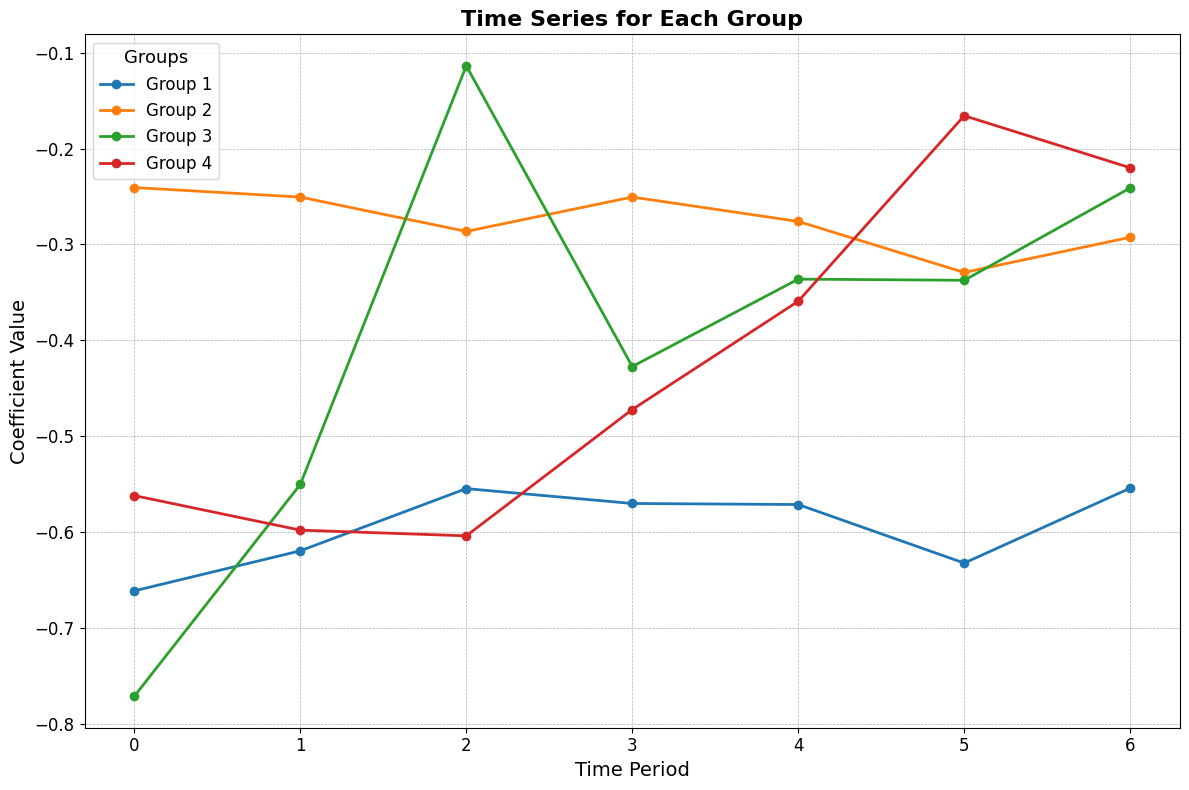

In [185]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure for the plot with APA style
plt.figure(figsize=(12, 8))

# Plot the time series for each group
for group_index in range(num_groups):
    plt.plot(range(time_periods), alphas[group_index, :], marker='o', linestyle='-', linewidth=2, label=f'Group {group_index + 1}')

# APA style elements
plt.title("Time Series for Each Group", fontsize=16, fontweight='bold')
plt.xlabel("Time Period", fontsize=14)
plt.ylabel("Coefficient Value", fontsize=14)
plt.xticks(range(time_periods), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=12, title="Groups", title_fontsize='13')
plt.tight_layout()

# Save plot to file
plt.savefig('time_series_each_group_APA_professional.png')
plt.show()


In [215]:
print(best_grouping)

[['Algeria', 'Burundi', 'Cameroon', 'Chad', 'China', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Egypt, Arab Rep.', 'Gabon', 'Guinea', 'Indonesia', 'Iran', 'Jordan', 'Kenya', 'Mauritania', 'Morocco', 'Paraguay', 'Rwanda', 'Sierra Leone', 'Singapore', 'Syrian Arab Republic', 'Togo', 'Tunisia'], ['Australia', 'Austria', 'Belgium', 'Canada', 'Colombia', 'Costa Rica', 'Cyprus', 'Denmark', 'Dominican Republic', 'El Salvador', 'Finland', 'France', 'Guatemala', 'Iceland', 'India', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Luxembourg', 'Malaysia', 'Netherlands', 'New Zealand', 'Norway', 'Sri Lanka', 'Sweden', 'Switzerland', 'Thailand', 'Trinidad and Tobago', 'Turkey', 'United Kingdom', 'United States', 'Venezuela, RB'], ['Ecuador', 'Ghana', 'Greece', 'Honduras', 'Mexico', 'Nepal', 'Nigeria', 'Panama', 'Peru', 'Portugal', 'Spain', 'Uganda'], ['Argentina', 'Benin', 'Bolivia', 'Brazil', 'Burkina Faso', 'Central African Republic', 'Chile', 'Korea, Rep.', 'Madagascar', 'Malawi', '

In [216]:
# Create a list to hold the data
data_group = []

# Iterate through the groups and countries to populate the data list
for group_number, countries in enumerate(best_grouping, start=1):
    for country in countries:
        data_group.append({'country': country, 'Group': group_number})

# Create a DataFrame from the data list
df = pd.DataFrame(data_group)

# Perform an outer join based on the 'Country' column
df_merged = pd.merge(df, data, on='country', how='outer')

# Display the merged DataFrame
print(df_merged)

     country  Group  fhpolrigaug   lag_dem  lag_income
0    Algeria      1     0.166667  0.270000    8.104171
1    Algeria      1     0.000000  0.166667    8.141255
2    Algeria      1     0.166667  0.000000    8.206531
3    Algeria      1     0.166667  0.166667    8.469116
4    Algeria      1     0.500000  0.166667    8.612084
..       ...    ...          ...       ...         ...
625   Zambia      4     0.333333  0.333333    7.210035
626   Zambia      4     0.333333  0.333333    7.122066
627   Zambia      4     0.166667  0.333333    6.995224
628   Zambia      4     0.666667  0.166667    6.928319
629   Zambia      4     0.333333  0.666667    6.702427

[630 rows x 5 columns]


In [217]:
data_with_time = df_merged.copy()

# Initialize 'time' column
data_with_time['time'] = 0
current_country = None
time_counter = 0

# Update the 'time' column for each row
for index, row in data_with_time.iterrows():
    if row['country'] != current_country:
        current_country = row['country']
        time_counter = 0
    data_with_time.at[index, 'time'] = time_counter
    time_counter += 1

# Sort the DataFrame first by 'country' alphabetically and then by 'time' chronologically
data_with_time = data_with_time.sort_values(by=['country', 'time'], ascending=[True, True])

print(data_with_time)

     country  Group  fhpolrigaug   lag_dem  lag_income  time
0    Algeria      1     0.166667  0.270000    8.104171     0
1    Algeria      1     0.000000  0.166667    8.141255     1
2    Algeria      1     0.166667  0.000000    8.206531     2
3    Algeria      1     0.166667  0.166667    8.469116     3
4    Algeria      1     0.500000  0.166667    8.612084     4
..       ...    ...          ...       ...         ...   ...
625   Zambia      4     0.333333  0.333333    7.210035     2
626   Zambia      4     0.333333  0.333333    7.122066     3
627   Zambia      4     0.166667  0.333333    6.995224     4
628   Zambia      4     0.666667  0.166667    6.928319     5
629   Zambia      4     0.333333  0.666667    6.702427     6

[630 rows x 6 columns]


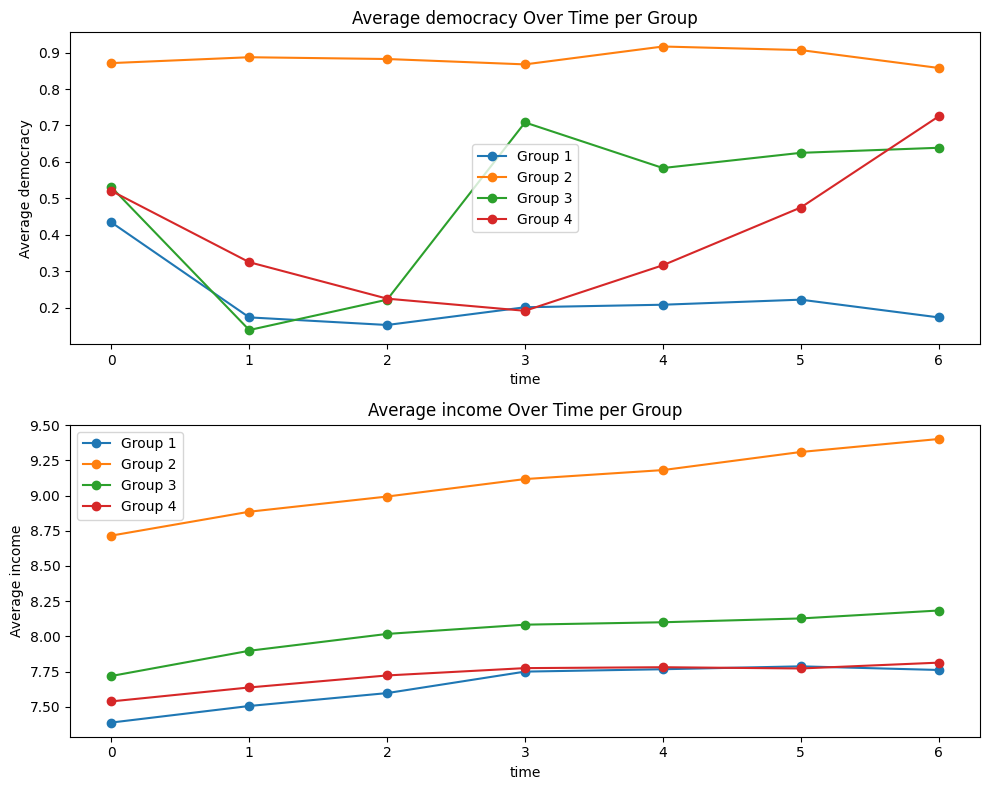

In [218]:
# Group by 'Group' and 'Time', then calculate the mean of 'lag_dem' and 'lag_income'
grouped_df = data_with_time.groupby(['Group', 'time']).agg({'lag_dem': 'mean', 'lag_income': 'mean'}).reset_index()

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot for lag_dem
for group in grouped_df['Group'].unique():
    group_data = grouped_df[grouped_df['Group'] == group]
    axes[0].plot(group_data['time'], group_data['lag_dem'], marker='o', label=f'Group {group}')

axes[0].set_title('Average democracy Over Time per Group')
axes[0].set_xlabel('time')
axes[0].set_ylabel('Average democracy')
axes[0].legend()

# Plot for lag_income
for group in grouped_df['Group'].unique():
    group_data = grouped_df[grouped_df['Group'] == group]
    axes[1].plot(group_data['time'], group_data['lag_income'], marker='o', label=f'Group {group}')

axes[1].set_title('Average income Over Time per Group')
axes[1].set_xlabel('time')
axes[1].set_ylabel('Average income')
axes[1].legend()

plt.tight_layout()
plt.show()

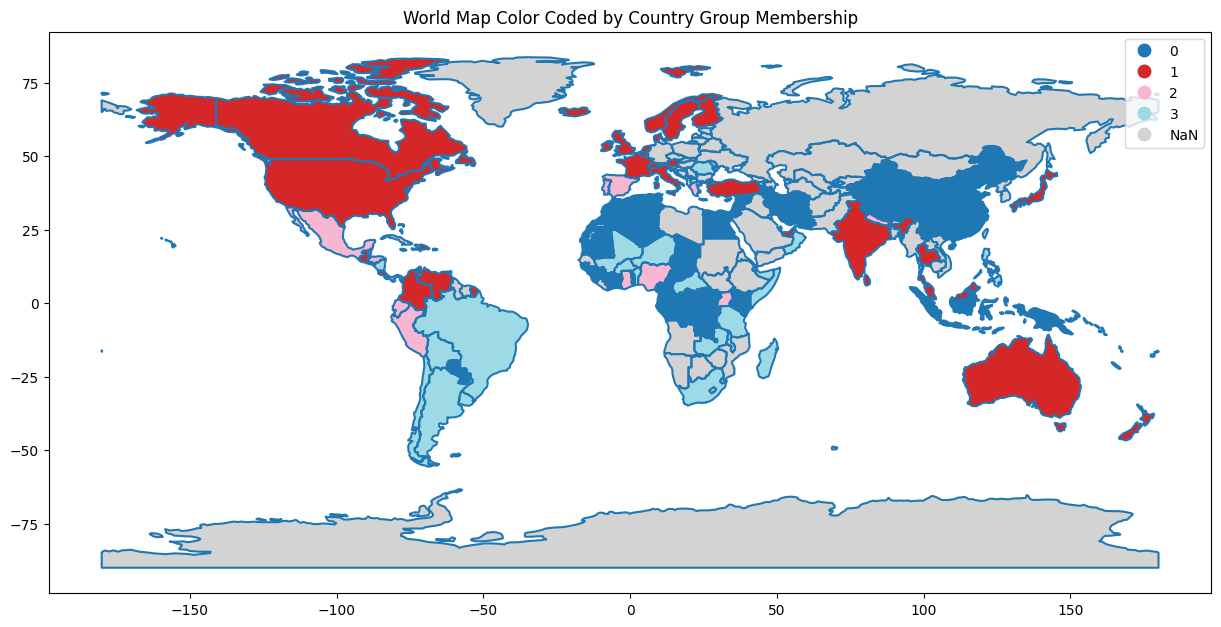

In [219]:
import geopandas as gpd
import matplotlib.pyplot as plt
from fuzzywuzzy import process

# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Flatten the list of country groups to create a dictionary with group assignments
country_group_dict = {}
        

for group_id, group in enumerate(best_grouping):
    for country in group:
        # if group_id == 3: 
        #     country_group_dict[country] = 3
        # elif group_id == 0:
        #     country_group_dict[country] = 1
        # elif group_id == 1:
        #     country_group_dict[country] = 2
        # else:
        #     country_group_dict[country] = 0
        country_group_dict[country] = group_id

# Function to get the best match for a country name using fuzzy matching
def get_best_match(country_name, choices):
    match, score = process.extractOne(country_name, choices)
    return match if score > 80 else None  # Adjust the threshold as needed

# Get the list of country names from the GeoDataFrame
country_choices = world['name'].tolist()

# Create a new column 'group' and initialize it with None
world['group'] = None

# Assign group IDs to each country in the GeoDataFrame using fuzzy matching
for idx, row in world.iterrows():
    best_match = get_best_match(row['name'], country_group_dict.keys())
    if best_match:
        world.at[idx, 'group'] = country_group_dict[best_match]

# Generate a color map
num_groups = len(best_grouping)
colors = plt.cm.get_cmap('tab20', num_groups)

# Plot the world map with color coding based on group membership
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
world.plot(column='group', ax=ax, legend=True, cmap=colors, missing_kwds={"color": "lightgrey"})

plt.title('World Map Color Coded by Country Group Membership')
plt.show()


In [118]:
country_group_dict

{'Algeria': 0,
 'Burundi': 0,
 'Cameroon': 0,
 'Chad': 0,
 'China': 0,
 'Congo, Dem. Rep.': 0,
 'Congo, Rep.': 0,
 "Cote d'Ivoire": 0,
 'Egypt, Arab Rep.': 0,
 'Gabon': 0,
 'Guinea': 0,
 'Indonesia': 0,
 'Iran': 0,
 'Jordan': 0,
 'Kenya': 0,
 'Mauritania': 0,
 'Morocco': 0,
 'Paraguay': 0,
 'Rwanda': 0,
 'Sierra Leone': 0,
 'Singapore': 0,
 'Syrian Arab Republic': 0,
 'Togo': 0,
 'Tunisia': 0,
 'Australia': 1,
 'Austria': 1,
 'Belgium': 1,
 'Canada': 1,
 'Colombia': 1,
 'Costa Rica': 1,
 'Cyprus': 1,
 'Denmark': 1,
 'Dominican Republic': 1,
 'El Salvador': 1,
 'Finland': 1,
 'France': 1,
 'Guatemala': 1,
 'Iceland': 1,
 'India': 1,
 'Ireland': 1,
 'Israel': 1,
 'Italy': 1,
 'Jamaica': 1,
 'Japan': 1,
 'Luxembourg': 1,
 'Malaysia': 1,
 'Netherlands': 1,
 'New Zealand': 1,
 'Norway': 1,
 'Sri Lanka': 1,
 'Sweden': 1,
 'Switzerland': 1,
 'Thailand': 1,
 'Trinidad and Tobago': 1,
 'Turkey': 1,
 'United Kingdom': 1,
 'United States': 1,
 'Venezuela, RB': 1,
 'Ecuador': 2,
 'Ghana': 2,
 'Gre

In [375]:
print("Best final_params:", best_final_params)

Best final_params: [0.60066864 0.06060938]


In [376]:
print("Best final_params:", best_final_params)

Best final_params: [0.60066864 0.06060938]


In [ ]:
print(best_grouping)
# [['Burundi', 'Benin', 'Central African Republic', 'China', "Cote d'Ivoire", 'Cameroon', 'Congo, Rep.', 'Algeria', 'Ecuador', 'Egypt, Arab Rep.', 'Gabon', 'Ghana', 'Guinea', 'Greece', 'Honduras', 'Iran', 'Jordan', 'Kenya', 'Madagascar', 'Mexico', 'Mali', 'Mauritania', 'Malawi', 'Niger', 'Nigeria', 'Panama', 'Peru', 'Philippines', 'Romania', 'Rwanda', 'Singapore', 'Sierra Leone', 'Syrian Arab Republic', 'Chad', 'Togo', 'Tunisia', 'Taiwan', 'Tanzania', 'Uganda', 'Congo, Dem. Rep.', 'Zambia'], 
# ['Argentina', 'Australia', 'Austria', 'Belgium', 'Burkina Faso', 'Bolivia', 'Brazil', 'Canada', 'Switzerland', 'Chile', 'Colombia', 'Costa Rica', 'Cyprus', 'Denmark', 'Dominican Republic', 'Spain', 'Finland', 'France', 'United Kingdom', 'Guatemala', 'Indonesia', 'India', 'Ireland', 'Iceland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Korea, Rep.', 'Sri Lanka', 'Luxembourg', 'Morocco', 'Malaysia', 'Nicaragua', 'Netherlands', 'Norway', 'Nepal', 'New Zealand', 'Portugal', 'Paraguay', 'El Salvador', 'Sweden', 'Thailand', 'Trinidad and Tobago', 'Turkey', 'Uruguay', 'United States', 'Venezuela, RB', 'South Africa']]

[['Burundi', 'Benin', 'Brazil', 'Central African Republic', 'China', "Cote d'Ivoire", 'Cameroon', 'Congo, Rep.', 'Algeria', 'Ecuador', 'Egypt, Arab Rep.', 'Gabon', 'Ghana', 'Guinea', 'Greece', 'Honduras', 'Iran', 'Jordan', 'Kenya', 'Madagascar', 'Mexico', 'Mali', 'Mauritania', 'Malawi', 'Niger', 'Nigeria', 'Panama', 'Peru', 'Philippines', 'Romania', 'Rwanda', 'Singapore', 'Sierra Leone', 'Syrian Arab Republic', 'Chad', 'Togo', 'Tunisia', 'Taiwan', 'Tanzania', 'Uganda', 'Congo, Dem. Rep.', 'Zambia'], ['Argentina', 'Australia', 'Austria', 'Belgium', 'Burkina Faso', 'Bolivia', 'Canada', 'Switzerland', 'Chile', 'Colombia', 'Costa Rica', 'Cyprus', 'Denmark', 'Dominican Republic', 'Spain', 'Finland', 'France', 'United Kingdom', 'Guatemala', 'Indonesia', 'India', 'Ireland', 'Iceland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Korea, Rep.', 'Sri Lanka', 'Luxembourg', 'Morocco', 'Malaysia', 'Nicaragua', 'Netherlands', 'Norway', 'Nepal', 'New Zealand', 'Portugal', 'Paraguay', 'El Salvador', 'Swede

In [10]:
import random
import warnings
import numpy as np
import pandas as pd
from sklearn.exceptions import DataConversionWarning

# Suppress specific warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*Series.__getitem__ treating keys as positions is deprecated.*")
warnings.filterwarnings("ignore", category=DataConversionWarning)

# Assuming necessary functions (initialisation, GFEAlgo1, iterative_part) are defined earlier

# Function to create bootstrapped data
def create_bootstrap_sample(data, unique_countries, n_samples=90):
    sampled_countries = np.random.choice(unique_countries, size=n_samples, replace=True)
    bootstrap_data = pd.DataFrame()
    new_country_to_rows = {}
    new_country_to_pos_unique = {}

    for i, country in enumerate(sampled_countries):
        country_data = data[data['country'] == country].copy()
        new_country_name = f"{country}_{i}"  # Make each country instance unique
        country_data['country'] = new_country_name  # Update country names in the sample
        bootstrap_data = pd.concat([bootstrap_data, country_data])
        
        # Update new_country_to_rows dictionary
        if new_country_name not in new_country_to_rows:
            new_country_to_rows[new_country_name] = list(country_data.index)
        
        # Update new_country_to_pos_unique dictionary
        if new_country_name not in new_country_to_pos_unique:
            new_country_to_pos_unique[new_country_name] = i
    
    return bootstrap_data, new_country_to_rows, new_country_to_pos_unique

# Function to initialize country_to_rows
def initialize_country_to_rows(data):
    country_to_rows = dict()
    unique_countries = data['country'].unique()
    
    for i in range(len(data)):
        current_country = data.iloc[i]['country']
        
        if current_country not in country_to_rows:
            country_to_rows[current_country] = [i]
        else:
            country_to_rows[current_country].append(i)
    
    return country_to_rows

# Main bootstrap procedure for GIFE
def bootstrap_gife(data, B=1000, num_groups=4, components=1, indep=['lag_dem', 'lag_income'], dep='fhpolrigaug'):
    unique_countries = data['country'].unique()
    bootstrap_estimates = []
    cumulative_income_estimates = []
    
    for b in range(B):
        print(f"Bootstrap iteration {b+1} for components = {components}")
        bootstrap_data, new_country_to_rows, new_country_to_pos_unique = create_bootstrap_sample(data, unique_countries)
        
        best_sse = float('inf')
        best_final_params = None
        best_grouping = None
        best_F = None
        best_lambda = None
        
        for _ in range(10):
            int_theta, F, Lambda, group_membership, SSR = initialisation(num_groups, bootstrap_data, indep, dep, components, new_country_to_rows)
            group_lambda = np.zeros((len(group_membership), components))
            for i in range(len(group_membership)):
                first_in_group = group_membership[i][0]
                group_lambda[i,:] = Lambda[new_country_to_pos_unique[first_in_group]]
            
            theta, F, Lambda, SSR, group_membership, IC = GFEAlgo1(int_theta, F @ group_lambda.T, num_groups, indep, dep, bootstrap_data, components, new_country_to_rows, group_membership, new_country_to_pos_unique, 0)
            #theta, F, Lambda, SSR, group_membership, IC = iterative_part(theta, SSR, group_membership, indep, dep, bootstrap_data, 0, 10, num_groups, new_country_to_rows, components, F, Lambda, IC, new_country_to_pos_unique)    

            if SSR < best_sse:
                best_sse = SSR
                best_final_params = theta
                best_grouping = group_membership
                best_F = F
                best_lambda = Lambda

        theta = best_final_params.flatten()
        bootstrap_estimates.append(theta)
        
        cumulative_income = theta[1] / (1 - theta[0])
        cumulative_income_estimates.append(cumulative_income)
    
    bootstrap_estimates = np.array(bootstrap_estimates)
    bootstrap_se = np.std(bootstrap_estimates, axis=0)
    cumulative_income_estimates = np.array(cumulative_income_estimates)
    cumulative_income_se = np.std(cumulative_income_estimates, axis=0)
    
    return bootstrap_estimates, bootstrap_se, cumulative_income_estimates, cumulative_income_se

# Example usage for components = 1 to 7
for components in range(1, 8):
    bootstrap_estimates, bootstrap_se, cumulative_income_estimates, cumulative_income_se = bootstrap_gife(data_with_time, B=100, num_groups=4, components=components, indep=['lag_dem', 'lag_income'], dep='fhpolrigaug')
    print(f"Components: {components}")
    print("Bootstrap Standard Errors:", bootstrap_se)
    print("Bootstrap Cumulative Income Standard Error:", cumulative_income_se)
    print("-------------------------------------------------")


Bootstrap iteration 1 for components = 1
Bootstrap iteration 2 for components = 1
Bootstrap iteration 3 for components = 1
Bootstrap iteration 4 for components = 1
Bootstrap iteration 5 for components = 1
Bootstrap iteration 6 for components = 1
Bootstrap iteration 7 for components = 1
Bootstrap iteration 8 for components = 1
Bootstrap iteration 9 for components = 1
Bootstrap iteration 10 for components = 1
Bootstrap iteration 11 for components = 1
Bootstrap iteration 12 for components = 1
Bootstrap iteration 13 for components = 1
Bootstrap iteration 14 for components = 1
Bootstrap iteration 15 for components = 1
Bootstrap iteration 16 for components = 1
Bootstrap iteration 17 for components = 1
Bootstrap iteration 18 for components = 1
Bootstrap iteration 19 for components = 1
Bootstrap iteration 20 for components = 1
Bootstrap iteration 21 for components = 1
Bootstrap iteration 22 for components = 1
Bootstrap iteration 23 for components = 1
Bootstrap iteration 24 for components = 1
B

In [13]:
def calculate_misclassification_rate(reference_list, target_list):
    # Ensure the elements in the lists are sets
    reference_sets = [set(sublist) for sublist in reference_list]
    target_sets = [set(sublist) for sublist in target_list]

    total_elements = sum(len(s) for s in reference_sets)
    misclassified_elements = 0

    target_sets_copy = target_sets.copy()
    
    for ref_set in reference_sets:
        # Find the best matching set in the target list
        best_match = max(target_sets_copy, key=lambda tgt_set: len(ref_set & tgt_set), default=set())
        
        # Calculate misclassified elements (elements in ref_set not in best_match)
        misclassified_elements += len(ref_set - best_match)
        # Remove the best match from target list copy to avoid reuse
        target_sets_copy.remove(best_match)
    
    misclassification_rate = misclassified_elements / total_elements
    return misclassification_rate


In [24]:
import random
import warnings
import numpy as np
import pandas as pd
import time
from sklearn.exceptions import DataConversionWarning

# Suppress specific warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*Series.__getitem__ treating keys as positions is deprecated.*")
warnings.filterwarnings("ignore", category=DataConversionWarning)

sse_list = []
final_params_list = []
misclassification_rate_list = []

# Parameters
num_groups = 3
num_individuals = 100
time_periods = 50
prop_individuals = [0.5, 0.3, 0.2]
#prop_individuals = [0.06, 0.22, 0.2, 0.04, 0.06, 0.04, 0.1, 0.06, 0.14, 0.08]
num_regressors = 2
theta_start = [1.5, 2.0]
components = 3
indep = ['x1', 'x2']

# Function to generate panel data with groups and factors
def generate_panel_data_with_factors(num_groups, num_individuals, prop_individuals, num_regressors, theta, time_periods, components):
    assert np.isclose(sum(prop_individuals), 1), "Proportions must sum to 1"
    
    group_sizes = (np.array(prop_individuals) * num_individuals).astype(int)
    group_labels = [f'Group_{i+1}' for i in range(num_groups)]
    
    individual_labels = []
    group_assignments = []
    individual_counter = 1
    for group, size in zip(group_labels, group_sizes):
        for _ in range(size):
            individual_labels.append(f'Individual_{individual_counter}')
            group_assignments.append(group)
            individual_counter += 1
    
    data = []
    F_t = np.random.normal(loc=0, scale=1, size=(time_periods, components))
    lambdas = {group: np.random.normal(loc=0, scale=10, size=components) for group in group_labels}
    for individual, group in zip(individual_labels, group_assignments):
        for t in range(time_periods):
            x_it = np.random.normal(0, 1, num_regressors)
            epsilon_it = np.random.normal(0, np.sqrt(1 + 0.1 * np.sum(x_it**2)/(num_regressors * num_individuals)))
            y_it = np.dot(x_it, theta) + np.dot(lambdas[group], F_t[t]) + epsilon_it
            data.append([individual, float(y_it), group] + list(x_it))  # Ensure y_it is a scalar
    
    columns = ['individual', 'y', 'group'] + [f'x{i+1}' for i in range(num_regressors)]
    df = pd.DataFrame(data, columns=columns)
    
    # Initialize 'time' column
    df['time'] = 0
    current_country = None
    time_counter = 0

    # Update the 'time' column for each row
    for index, row in df.iterrows():
        if row['individual'] != current_country:
            current_country = row['individual']
            time_counter = 0
        df.at[index, 'time'] = time_counter
        time_counter += 1
    
    group_memberships = pd.DataFrame({'individual': individual_labels, 'group': group_assignments})
    
    return df, F_t, lambdas, group_memberships


# Number of datasets and estimator iterations
num_datasets = 100
num_iterations = 10

# Initialize storage for results
best_params_matrix = np.zeros((num_datasets, len(theta)))
infeasible_params_matrix = np.zeros((num_datasets, len(theta)))
best_sse_vector = np.zeros(num_datasets)
misclassification_rate_vector = np.zeros(num_datasets)

gife = GroupedInteractiveFixedEffects(components)

for dataset_index in range(num_datasets):
    df, F_t, lambdas, group_memberships = generate_panel_data_with_factors(num_groups, num_individuals, prop_individuals, num_regressors, theta_start, time_periods, components)
    data = df.copy()
    data.rename(columns={'individual': 'country'}, inplace=True)
    
    unique_countries = data['country'].unique()
    groups = data[['country', 'group']].drop_duplicates()
    
    perfect_grouped_countries = groups.groupby('group')['country'].apply(list).tolist()
    
    country_to_pos_unique = dict()
    for i, country in enumerate(unique_countries):
        country_to_pos_unique[country] = i
    
    unique_countries = data['country'].unique()
    groups = data[['country', 'group']].drop_duplicates()
    
    country_to_rows = dict()
    for i in range(len(data)):
        current_country = data.iloc[i]['country']
        if current_country not in country_to_rows.keys():
            country_to_rows[current_country] = [i]
        else:
            country_to_rows[current_country].append(i)
    
    gife.reset_estimation()
    
    theta, F, Lambda, SSR, IC = gife.fit(
                        data['y'].values[:, np.newaxis].astype(float),  # Ensure float type
                        data[indep].values.astype(float),  # Ensure float type
                        data['country'].values[:, np.newaxis],  # Group identifiers
                        data['time'].values[:, np.newaxis],  # Time periods
                        country_to_rows,
                        perfect_grouped_countries
                    )
    infeasible_params_matrix[dataset_index, :] = theta.flatten()
    
    print("Infeasible theta: ", theta)
    
    y = data['y'].to_numpy().astype(float)
    X = data[['x1', 'x2']].to_numpy().astype(float)
    
    best_sse = float('inf')
    best_final_params = None
    best_grouping = None
    best_misclassification_rate = None
    
    # Track the runtime to reach the lowest SSE
    start_time = time.time()
    best_runtime = 0
    
    # Matrix to store final parameters for each iteration
    final_params_matrix = np.zeros((num_iterations, len(indep)))
    
    for iteration in range(num_iterations):
        sampled_theta, F, Lambda, group_membership, SSR = initialisation(num_groups, data, indep, 'y', components, country_to_rows)
        group_lambda = np.zeros((len(group_membership), components))
        for i in range(len(group_membership)):
            first_in_group = group_membership[i][0]
            group_lambda[i,:] = Lambda[country_to_pos_unique[first_in_group]]
        
        ### use different components value
        theta, F, Lambda, SSR, group_membership, IC = GFEAlgo1(sampled_theta, F @ group_lambda.T, num_groups, indep, 'y', data, components, country_to_rows, group_membership, country_to_pos_unique, 0)
        
        misclassification_rate = calculate_misclassification_rate(perfect_grouped_countries, group_membership)
        
        sse_list.append(SSR)
        final_params_list.append(theta)
        misclassification_rate_list.append(misclassification_rate)
        
        final_params_matrix[iteration] = theta.flatten()
        
        if SSR < best_sse:
            best_sse = SSR
            best_final_params = theta.flatten()
            best_grouping = group_membership
            best_misclassification_rate = misclassification_rate
            best_runtime = time.time() - start_time
    
    best_params_matrix[dataset_index, :] = best_final_params
    best_sse_vector[dataset_index] = best_sse
    misclassification_rate_vector[dataset_index] = best_misclassification_rate
    
    
    print("Best SSE Vector:", np.mean(best_sse_vector))
    print("Misclassification Rate Vector:", misclassification_rate_vector)
    print("params:")
    print(best_params_matrix)
    print("Infeasible params:")
    print(infeasible_params_matrix)

# Print results
print("Best SSE Vector:", np.mean(best_sse_vector))
print("Misclassification Rate Vector:", np.mean(misclassification_rate_vector))
print("Bias:")
print(np.mean(best_params_matrix, axis=0) - [1.5, 2])
print("Infeasible Bias:")
print(np.mean(infeasible_params_matrix, axis=0) - [1.5, 2])

# Calculate the differences
differences = best_params_matrix - [1.5, 2]
infeasible_differences = infeasible_params_matrix - [1.5, 2]

# Square the differences
squared_differences = differences ** 2
infeasible_squared_differences = infeasible_differences ** 2

# Calculate the mean of the squared differences
mean_squared_differences = np.mean(squared_differences, axis=0)
mean_squared_infeasible_differences = np.mean(infeasible_squared_differences, axis=0)

# Take the square root of the mean squared differences to get RMSE
rmse = np.sqrt(mean_squared_differences)
infeasible_rmse = np.sqrt(mean_squared_infeasible_differences)

print("RMSE:", rmse)
print("Infeasible RMSE:", infeasible_rmse)

# Define the actual parameter values
actual_param1 = 1.5
actual_param2 = 2.0

# Calculate standard deviation for each column
std_devs = np.std(best_params_matrix, axis=0)
infeasible_std_devs = np.std(infeasible_params_matrix, axis=0)

# Define a function to calculate the confidence interval for each observation
def calculate_confidence_interval(value, std, z_score=1.96):
    margin_of_error = z_score * std
    lower_bound = value - margin_of_error
    upper_bound = value + margin_of_error
    return lower_bound, upper_bound

# Calculate the confidence interval for each observation in column1
ci_includes_param1 = []
infeasible_ci_includes_param1 = []
for value in best_params_matrix[:, 0]:
    lower_bound, upper_bound = calculate_confidence_interval(value, std_devs[0])
    ci_includes_param1.append(lower_bound <= actual_param1 <= upper_bound)
for value in infeasible_params_matrix[:, 0]:
    lower_bound, upper_bound = calculate_confidence_interval(value, infeasible_std_devs[0])
    infeasible_ci_includes_param1.append(lower_bound <= actual_param1 <= upper_bound)

# Calculate the confidence interval for each observation in column2
ci_includes_param2 = []
infeasible_ci_includes_param2 = []
for value in best_params_matrix[:, 1]:
    lower_bound, upper_bound = calculate_confidence_interval(value, std_devs[1])
    ci_includes_param2.append(lower_bound <= actual_param2 <= upper_bound)
for value in infeasible_params_matrix[:, 1]:
    lower_bound, upper_bound = calculate_confidence_interval(value, infeasible_std_devs[1])
    infeasible_ci_includes_param2.append(lower_bound <= actual_param2 <= upper_bound)

# Calculate the percentage of confidence intervals that include the actual parameter value
percentage_includes_param1 = (np.sum(ci_includes_param1) / len(ci_includes_param1)) * 100
percentage_includes_param2 = (np.sum(ci_includes_param2) / len(ci_includes_param2)) * 100

infeasible_percentage_includes_param1 = (np.sum(infeasible_ci_includes_param1) / len(infeasible_ci_includes_param1)) * 100
infeasible_percentage_includes_param2 = (np.sum(infeasible_ci_includes_param2) / len(infeasible_ci_includes_param2)) * 100

print(f"Percentage of confidence intervals in column1 that include the actual value {actual_param1}: {percentage_includes_param1:.2f}%")
print(f"Percentage of confidence intervals in column2 that include the actual value {actual_param2}: {percentage_includes_param2:.2f}%")
print(f"Infeasible percentage of confidence intervals in column1 that include the actual value {actual_param1}: {infeasible_percentage_includes_param1:.2f}%")
print(f"Infeasible percentage of confidence intervals in column2 that include the actual value {actual_param2}: {infeasible_percentage_includes_param2:.2f}%")

Infeasible theta:  [[1.50721021]
 [2.01350779]]
Best SSE Vector: 49.37759098931295
Misclassification Rate Vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
params:
[[1.50721021 2.01350779]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.       

In [10]:
import random
import warnings
import numpy as np
import pandas as pd
import time
from sklearn.exceptions import DataConversionWarning

# Suppress specific warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*Series.__getitem__ treating keys as positions is deprecated.*")
warnings.filterwarnings("ignore", category=DataConversionWarning)

sse_list = []
final_params_list = []
misclassification_rate_list = []

# Parameters
num_groups = 3
num_individuals = 100
time_periods = 50
prop_individuals = [0.5, 0.3, 0.2]
#prop_individuals = [0.06, 0.22, 0.2, 0.04, 0.06, 0.04, 0.1, 0.06, 0.14, 0.08]
num_regressors = 2
theta_start = [1.5, 2.0]
components = 3
indep = ['x1', 'x2']

# Function to generate panel data with groups and factors
def generate_panel_data_with_factors(num_groups, num_individuals, prop_individuals, num_regressors, theta, time_periods, components):
    assert np.isclose(sum(prop_individuals), 1), "Proportions must sum to 1"
    
    group_sizes = (np.array(prop_individuals) * num_individuals).astype(int)
    group_labels = [f'Group_{i+1}' for i in range(num_groups)]
    
    individual_labels = []
    group_assignments = []
    individual_counter = 1
    for group, size in zip(group_labels, group_sizes):
        for _ in range(size):
            individual_labels.append(f'Individual_{individual_counter}')
            group_assignments.append(group)
            individual_counter += 1
    
    data = []
    F_t = np.random.normal(loc=0, scale=1, size=(time_periods, components))
    lambdas = {group: np.random.normal(loc=0, scale=10, size=components) for group in group_labels}
    for individual, group in zip(individual_labels, group_assignments):
        for t in range(time_periods):
            x_it = np.random.normal(0, 1, num_regressors)
            epsilon_it = np.random.normal(0, np.sqrt(1 + 0.1 * np.sum(x_it**2)/(num_regressors * num_individuals)))
            y_it = np.dot(x_it, theta) + np.dot(lambdas[group], F_t[t]) + epsilon_it
            data.append([individual, float(y_it), group] + list(x_it))  # Ensure y_it is a scalar
    
    columns = ['individual', 'y', 'group'] + [f'x{i+1}' for i in range(num_regressors)]
    df = pd.DataFrame(data, columns=columns)
    
    # Initialize 'time' column
    df['time'] = 0
    current_country = None
    time_counter = 0

    # Update the 'time' column for each row
    for index, row in df.iterrows():
        if row['individual'] != current_country:
            current_country = row['individual']
            time_counter = 0
        df.at[index, 'time'] = time_counter
        time_counter += 1
    
    group_memberships = pd.DataFrame({'individual': individual_labels, 'group': group_assignments})
    
    return df, F_t, lambdas, group_memberships


# Number of datasets and estimator iterations
num_datasets = 100
num_iterations = 100

# Initialize storage for results
best_params_matrix = np.zeros((num_datasets, len(theta_start)))
infeasible_params_matrix = np.zeros((num_datasets, len(theta_start)))
best_sse_vector = np.zeros(num_datasets)
misclassification_rate_vector = np.zeros(num_datasets)

gife = GroupedInteractiveFixedEffects(components)

for dataset_index in range(num_datasets):
    df, F_t, lambdas, group_memberships = generate_panel_data_with_factors(num_groups, num_individuals, prop_individuals, num_regressors, theta_start, time_periods, components)
    data = df.copy()
    data.rename(columns={'individual': 'country'}, inplace=True)
    
    unique_countries = data['country'].unique()
    groups = data[['country', 'group']].drop_duplicates()
    
    perfect_grouped_countries = groups.groupby('group')['country'].apply(list).tolist()
    
    country_to_pos_unique = dict()
    for i, country in enumerate(unique_countries):
        country_to_pos_unique[country] = i
    
    country_to_rows = dict()
    for i in range(len(data)):
        current_country = data.iloc[i]['country']
        if current_country not in country_to_rows.keys():
            country_to_rows[current_country] = [i]
        else:
            country_to_rows[current_country].append(i)
    
    gife.reset_estimation()
    
    theta, F, Lambda, SSR = gife.fit(
                        data['y'].values[:, np.newaxis].astype(float),  # Ensure float type
                        data[indep].values.astype(float),  # Ensure float type
                        data['country'].values[:, np.newaxis],  # Group identifiers
                        data['time'].values[:, np.newaxis],  # Time periods
                        country_to_rows,
                        perfect_grouped_countries
                    )
    infeasible_params_matrix[dataset_index, :] = theta.flatten()
    
    print("Infeasible theta: ", theta)
    
    y = data['y'].to_numpy().astype(float)
    X = data[['x1', 'x2']].to_numpy().astype(float)
    
    best_sse = float('inf')
    best_final_params = None
    best_grouping = None
    best_misclassification_rate = None
    
    # Track the runtime to reach the lowest SSE
    start_time = time.time()
    best_runtime = 0
    
    # Matrix to store final parameters for each iteration
    final_params_matrix = np.zeros((num_iterations, len(indep)))
    
    for iteration in range(num_iterations):
        sampled_theta, F, Lambda, group_membership, SSR = initialisation(num_groups, data, indep, 'y', components)
        group_lambda = np.zeros((len(group_membership), components))
        for i in range(len(group_membership)):
            first_in_group = group_membership[i][0]
            group_lambda[i,:] = Lambda[country_to_pos_unique[first_in_group]]
        
        ### use different components value
        theta, F, Lambda, SSR, group_membership = GFEAlgo1(sampled_theta, F @ group_lambda.T, num_groups, indep, 'y', data, components, country_to_rows, group_membership, country_to_pos_unique, 0)
        
        misclassification_rate = calculate_misclassification_rate(perfect_grouped_countries, group_membership)
        
        sse_list.append(SSR)
        final_params_list.append(theta)
        misclassification_rate_list.append(misclassification_rate)
        
        final_params_matrix[iteration] = theta.flatten()
        
        if SSR < best_sse:
            best_sse = SSR
            best_final_params = theta.flatten()
            best_grouping = group_membership
            best_misclassification_rate = misclassification_rate
            best_runtime = time.time() - start_time
    
    best_params_matrix[dataset_index, :] = best_final_params
    best_sse_vector[dataset_index] = best_sse
    misclassification_rate_vector[dataset_index] = best_misclassification_rate
    
    print("Best SSE Vector:", np.mean(best_sse_vector))
    print("Misclassification Rate Vector:", misclassification_rate_vector)
    print("params:")
    print(best_params_matrix)
    print("Infeasible params:")
    print(infeasible_params_matrix)

# Print results
print("Best SSE Vector:", np.mean(best_sse_vector))
print("Misclassification Rate Vector:", np.mean(misclassification_rate_vector))
print("Bias:")
print(np.mean(best_params_matrix, axis=0) - [1.5, 2])
print("Infeasible Bias:")
print(np.mean(infeasible_params_matrix, axis=0) - [1.5, 2])

# Calculate the differences
differences = best_params_matrix - [1.5, 2]
infeasible_differences = infeasible_params_matrix - [1.5, 2]

# Square the differences
squared_differences = differences ** 2
infeasible_squared_differences = infeasible_differences ** 2

# Calculate the mean of the squared differences
mean_squared_differences = np.mean(squared_differences, axis=0)
mean_squared_infeasible_differences = np.mean(infeasible_squared_differences, axis=0)

# Take the square root of the mean squared differences to get RMSE
rmse = np.sqrt(mean_squared_differences)
infeasible_rmse = np.sqrt(mean_squared_infeasible_differences)

print("RMSE:", rmse)
print("Infeasible RMSE:", infeasible_rmse)

# Define the actual parameter values
actual_param1 = 1.5
actual_param2 = 2.0

# Calculate standard deviation for each column
std_devs = np.std(best_params_matrix, axis=0)
infeasible_std_devs = np.std(infeasible_params_matrix, axis=0)

# Define a function to calculate the confidence interval for each observation
def calculate_confidence_interval(value, std, z_score=1.96):
    margin_of_error = z_score * std
    lower_bound = value - margin_of_error
    upper_bound = value + margin_of_error
    return lower_bound, upper_bound

# Calculate the confidence interval for each observation in column1
ci_includes_param1 = []
infeasible_ci_includes_param1 = []
for value in best_params_matrix[:, 0]:
    lower_bound, upper_bound = calculate_confidence_interval(value, std_devs[0])
    ci_includes_param1.append(lower_bound <= actual_param1 <= upper_bound)
for value in infeasible_params_matrix[:, 0]:
    lower_bound, upper_bound = calculate_confidence_interval(value, infeasible_std_devs[0])
    infeasible_ci_includes_param1.append(lower_bound <= actual_param1 <= upper_bound)

# Calculate the confidence interval for each observation in column2
ci_includes_param2 = []
infeasible_ci_includes_param2 = []
for value in best_params_matrix[:, 1]:
    lower_bound, upper_bound = calculate_confidence_interval(value, std_devs[1])
    ci_includes_param2.append(lower_bound <= actual_param2 <= upper_bound)
for value in infeasible_params_matrix[:, 1]:
    lower_bound, upper_bound = calculate_confidence_interval(value, infeasible_std_devs[1])
    infeasible_ci_includes_param2.append(lower_bound <= actual_param2 <= upper_bound)

# Calculate the percentage of confidence intervals that include the actual parameter value
percentage_includes_param1 = (np.sum(ci_includes_param1) / len(ci_includes_param1)) * 100
percentage_includes_param2 = (np.sum(ci_includes_param2) / len(ci_includes_param2)) * 100

infeasible_percentage_includes_param1 = (np.sum(infeasible_ci_includes_param1) / len(infeasible_ci_includes_param1)) * 100
infeasible_percentage_includes_param2 = (np.sum(infeasible_ci_includes_param2) / len(infeasible_ci_includes_param2)) * 100

print(f"Percentage of confidence intervals in column1 that include the actual value {actual_param1}: {percentage_includes_param1:.2f}%")
print(f"Percentage of confidence intervals in column2 that include the actual value {actual_param2}: {percentage_includes_param2:.2f}%")
print(f"Infeasible percentage of confidence intervals in column1 that include the actual value {actual_param1}: {infeasible_percentage_includes_param1:.2f}%")
print(f"Infeasible percentage of confidence intervals in column2 that include the actual value {actual_param2}: {infeasible_percentage_includes_param2:.2f}%")


ValueError: too many values to unpack (expected 4)

In [86]:

# Print results
print("Best SSE Vector:", np.mean(best_sse_vector))
print("Misclassification Rate Vector:", np.mean(misclassification_rate_vector))
print("Bias:")
print(np.mean(best_params_matrix, axis=0) - [1.5, 2])

# Calculate the differences
differences = best_params_matrix - [1.5, 2]

# Square the differences
squared_differences = differences ** 2

# Calculate the mean of the squared differences
mean_squared_differences = np.mean(squared_differences, axis=0)

# Take the square root of the mean squared differences to get RMSE
rmse = np.sqrt(mean_squared_differences)

print(rmse)

# Define the actual parameter values
actual_param1 = 1.5
actual_param2 = 2.0

# Calculate standard deviation for each column
std_devs = np.std(best_params_matrix, axis=0)

# Define a function to calculate the confidence interval for each observation
def calculate_confidence_interval(value, std, z_score=1.96):
    margin_of_error = z_score * std
    lower_bound = value - margin_of_error
    upper_bound = value + margin_of_error
    return lower_bound, upper_bound

# Calculate the confidence interval for each observation in column1
ci_includes_param1 = []
for value in best_params_matrix[:, 0]:
    lower_bound, upper_bound = calculate_confidence_interval(value, std_devs[0])
    ci_includes_param1.append(lower_bound <= actual_param1 <= upper_bound)

# Calculate the confidence interval for each observation in column2
ci_includes_param2 = []
for value in best_params_matrix[:, 1]:
    lower_bound, upper_bound = calculate_confidence_interval(value, std_devs[1])
    ci_includes_param2.append(lower_bound <= actual_param2 <= upper_bound)

# Calculate the percentage of confidence intervals that include the actual parameter value
percentage_includes_param1 = (np.sum(ci_includes_param1) / len(ci_includes_param1)) * 100
percentage_includes_param2 = (np.sum(ci_includes_param2) / len(ci_includes_param2)) * 100

print(f"Percentage of confidence intervals in column1 that include the actual value {actual_param1}: {percentage_includes_param1:.2f}%")
print(f"Percentage of confidence intervals in column2 that include the actual value {actual_param2}: {percentage_includes_param2:.2f}%")

Best SSE Vector: 78.82255183909706
Misclassification Rate Vector: 0.030625
Bias:
[-0.97400991 -1.10389985]
[1.14894824 1.51197307]
Percentage of confidence intervals in column1 that include the actual value 1.5: 43.00%
Percentage of confidence intervals in column2 that include the actual value 2.0: 100.00%


In [11]:
import random
import warnings
import numpy as np
import pandas as pd
import time
from sklearn.exceptions import DataConversionWarning

# Suppress specific warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*Series.__getitem__ treating keys as positions is deprecated.*")
warnings.filterwarnings("ignore", category=DataConversionWarning)

sse_list = []
final_params_list = []
misclassification_rate_list = []

# Parameters
num_groups = 3
num_individuals = 100
time_periods = 50
prop_individuals = [0.5, 0.3, 0.2]
#prop_individuals = [0.06, 0.22, 0.2, 0.04, 0.06, 0.04, 0.1, 0.06, 0.14, 0.08]
num_regressors = 2
theta_start = [1.5, 2.0]
components = 3
indep = ['x1', 'x2']

# Function to generate panel data with groups and factors
def generate_panel_data_with_factors(num_groups, num_individuals, prop_individuals, num_regressors, theta, time_periods, components):
    assert np.isclose(sum(prop_individuals), 1), "Proportions must sum to 1"
    
    group_sizes = (np.array(prop_individuals) * num_individuals).astype(int)
    group_labels = [f'Group_{i+1}' for i in range(num_groups)]
    
    individual_labels = []
    group_assignments = []
    individual_counter = 1
    for group, size in zip(group_labels, group_sizes):
        for _ in range(size):
            individual_labels.append(f'Individual_{individual_counter}')
            group_assignments.append(group)
            individual_counter += 1
    
    data = []
    F_t = np.random.normal(loc=0, scale=1, size=(time_periods, components))
    lambdas = {group: np.random.normal(loc=0, scale=10, size=components) for group in group_labels}
    for individual, group in zip(individual_labels, group_assignments):
        for t in range(time_periods):
            x_it = np.random.normal(0, 1, num_regressors)
            epsilon_it = np.random.normal(0, np.sqrt(0.4 + 0.1 * np.sum(x_it**2)/(num_regressors * num_individuals)))
            y_it = np.dot(x_it, theta) + np.dot(lambdas[group], F_t[t]) + epsilon_it
            data.append([individual, float(y_it), group] + list(x_it))  # Ensure y_it is a scalar
    
    columns = ['individual', 'y', 'group'] + [f'x{i+1}' for i in range(num_regressors)]
    df = pd.DataFrame(data, columns=columns)
    
    # Initialize 'time' column
    df['time'] = 0
    current_country = None
    time_counter = 0

    # Update the 'time' column for each row
    for index, row in df.iterrows():
        if row['individual'] != current_country:
            current_country = row['individual']
            time_counter = 0
        df.at[index, 'time'] = time_counter
        time_counter += 1
    
    group_memberships = pd.DataFrame({'individual': individual_labels, 'group': group_assignments})
    
    return df, F_t, lambdas, group_memberships


# Number of datasets and estimator iterations
num_datasets = 1000
num_iterations = 10

# Initialize storage for results
best_params_matrix = np.zeros((num_datasets, len(theta)))
infeasible_params_matrix = np.zeros((num_datasets, len(theta)))
best_sse_vector = np.zeros(num_datasets)
misclassification_rate_vector = np.zeros(num_datasets)

gife = GroupedInteractiveFixedEffects(components)

for dataset_index in range(num_datasets):
    df, F_t, lambdas, group_memberships = generate_panel_data_with_factors(num_groups, num_individuals, prop_individuals, num_regressors, theta_start, time_periods, components)
    data = df.copy()
    data.rename(columns={'individual': 'country'}, inplace=True)
    
    unique_countries = data['country'].unique()
    groups = data[['country', 'group']].drop_duplicates()
    
    perfect_grouped_countries = groups.groupby('group')['country'].apply(list).tolist()
    
    country_to_pos_unique = dict()
    for i, country in enumerate(unique_countries):
        country_to_pos_unique[country] = i
    
    unique_countries = data['country'].unique()
    groups = data[['country', 'group']].drop_duplicates()
    
    country_to_rows = dict()
    for i in range(len(data)):
        current_country = data.iloc[i]['country']
        if current_country not in country_to_rows.keys():
            country_to_rows[current_country] = [i]
        else:
            country_to_rows[current_country].append(i)
    
    gife.reset_estimation()
    
    theta, F, Lambda, SSR = gife.fit(
                        data['y'].values[:, np.newaxis].astype(float),  # Ensure float type
                        data[indep].values.astype(float),  # Ensure float type
                        data['country'].values[:, np.newaxis],  # Group identifiers
                        data['time'].values[:, np.newaxis],  # Time periods
                        country_to_rows,
                        perfect_grouped_countries
                    )
    infeasible_params_matrix[dataset_index, :] = theta.flatten()
    
#     print("Infeasible theta: ", theta)
    
#     y = data['y'].to_numpy().astype(float)
#     X = data[['x1', 'x2']].to_numpy().astype(float)
    
#     best_sse = float('inf')
#     best_final_params = None
#     best_grouping = None
#     best_misclassification_rate = None
    
#     # Track the runtime to reach the lowest SSE
#     start_time = time.time()
#     best_runtime = 0
    
#     # Matrix to store final parameters for each iteration
#     final_params_matrix = np.zeros((num_iterations, len(indep)))
    
#     for iteration in range(num_iterations):
#         sampled_theta, F, Lambda, group_membership, SSR = initialisation(num_groups, data, indep, 'y', components)
#         group_lambda = np.zeros((len(group_membership), components))
#         for i in range(len(group_membership)):
#             first_in_group = group_membership[i][0]
#             group_lambda[i,:] = Lambda[country_to_pos_unique[first_in_group]]
        
#         ### use different components value
#         theta, F, Lambda, SSR, group_membership = GFEAlgo1(sampled_theta, F @ group_lambda.T, num_groups, indep, 'y', data, components, country_to_rows, group_membership, country_to_pos_unique, 0)
        
#         misclassification_rate = calculate_misclassification_rate(perfect_grouped_countries, group_membership)
        
#         sse_list.append(SSR)
#         final_params_list.append(theta)
#         misclassification_rate_list.append(misclassification_rate)
        
#         final_params_matrix[iteration] = theta.flatten()
        
#         if SSR < best_sse:
#             best_sse = SSR
#             best_final_params = theta.flatten()
#             best_grouping = group_membership
#             best_misclassification_rate = misclassification_rate
#             best_runtime = time.time() - start_time
    
#     best_params_matrix[dataset_index, :] = best_final_params
#     best_sse_vector[dataset_index] = best_sse
#     misclassification_rate_vector[dataset_index] = best_misclassification_rate
    
#     print("Best SSE Vector:", np.mean(best_sse_vector))
#     print("Misclassification Rate Vector:", misclassification_rate_vector)
#     print("params:")
#     print(best_params_matrix)
    
        

# # Print results
# print("Best SSE Vector:", np.mean(best_sse_vector))
# print("Misclassification Rate Vector:", np.mean(misclassification_rate_vector))
# print("Bias:")
# print(np.mean(best_params_matrix, axis=0) - [1.5, 2])

# # Calculate the differences
# differences = best_params_matrix - [1.5, 2]

# # Square the differences
# squared_differences = differences ** 2

# # Calculate the mean of the squared differences
# mean_squared_differences = np.mean(squared_differences, axis=0)

# # Take the square root of the mean squared differences to get RMSE
# rmse = np.sqrt(mean_squared_differences)

# print(rmse)

# # Define the actual parameter values
# actual_param1 = 1.5
# actual_param2 = 2.0

# # Calculate standard deviation for each column
# std_devs = np.std(best_params_matrix, axis=0)

# # Define a function to calculate the confidence interval for each observation
# def calculate_confidence_interval(value, std, z_score=1.96):
#     margin_of_error = z_score * std
#     lower_bound = value - margin_of_error
#     upper_bound = value + margin_of_error
#     return lower_bound, upper_bound

# # Calculate the confidence interval for each observation in column1
# ci_includes_param1 = []
# for value in best_params_matrix[:, 0]:
#     lower_bound, upper_bound = calculate_confidence_interval(value, std_devs[0])
#     ci_includes_param1.append(lower_bound <= actual_param1 <= upper_bound)

# # Calculate the confidence interval for each observation in column2
# ci_includes_param2 = []
# for value in best_params_matrix[:, 1]:
#     lower_bound, upper_bound = calculate_confidence_interval(value, std_devs[1])
#     ci_includes_param2.append(lower_bound <= actual_param2 <= upper_bound)

# # Calculate the percentage of confidence intervals that include the actual parameter value
# percentage_includes_param1 = (np.sum(ci_includes_param1) / len(ci_includes_param1)) * 100
# percentage_includes_param2 = (np.sum(ci_includes_param2) / len(ci_includes_param2)) * 100

# print(f"Percentage of confidence intervals in column1 that include the actual value {actual_param1}: {percentage_includes_param1:.2f}%")
# print(f"Percentage of confidence intervals in column2 that include the actual value {actual_param2}: {percentage_includes_param2:.2f}%")


ValueError: too many values to unpack (expected 4)

In [235]:
print(np.mean(infeasible_params_matrix, axis = 0))


[1.4995917 1.9999362]
